In [11]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

In [12]:
import findspark
findspark.init()

In [13]:
findspark.find()

'/content/spark-3.4.2-bin-hadoop3'

SparkSesson variable

In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Pyspark_SQL")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [17]:
spark

## Analysis


Analizar el fichero usando pyspark para sacar una serie de conclusiones.
Importación del archivo


In [23]:
import pandas as pd

data_path = '/content/drive/MyDrive/TokioSchool/data/'

data = spark.read.options(inferSchema='True',delimiter=';', header=True).csv(data_path + 'StudentPerformance.csv')
data.show(3)

+-----+--------------+------------------+--------+-----------------------+---------------+------------------+------------------+---+
|index|race_ethnicity|parental_education|   lunch|test_preparation_course|math_percentage|reading_percentage|writing_percentage|sex|
+-----+--------------+------------------+--------+-----------------------+---------------+------------------+------------------+---+
|    0|       group B| bachelor's degree|standard|                   none|           0.72|              0.72|              0.74|  F|
|    1|       group C|      some college|standard|              completed|           0.69|               0.9|              0.88|  F|
|    2|       group B|   master's degree|standard|                   none|            0.9|              0.95|              0.93|  F|
+-----+--------------+------------------+--------+-----------------------+---------------+------------------+------------------+---+
only showing top 3 rows



In [24]:
data.printSchema() #Data types

root
 |-- index: integer (nullable = true)
 |-- race_ethnicity: string (nullable = true)
 |-- parental_education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test_preparation_course: string (nullable = true)
 |-- math_percentage: double (nullable = true)
 |-- reading_percentage: double (nullable = true)
 |-- writing_percentage: double (nullable = true)
 |-- sex: string (nullable = true)



In [25]:
data.describe().show() #Data summary

+-------+-----------------+--------------+------------------+------------+-----------------------+-------------------+-------------------+------------------+----+
|summary|            index|race_ethnicity|parental_education|       lunch|test_preparation_course|    math_percentage| reading_percentage|writing_percentage| sex|
+-------+-----------------+--------------+------------------+------------+-----------------------+-------------------+-------------------+------------------+----+
|  count|             1000|          1000|              1000|        1000|                   1000|               1000|               1000|              1000|1000|
|   mean|            499.5|          null|              null|        null|                   null|  0.660890000000001| 0.6916900000000004|0.6805400000000015|null|
| stddev|288.8194360957494|          null|              null|        null|                   null|0.15163080096009468|0.14600191937252227|0.1519565701086965|null|
|    min|             

**Checking for null values**


In [26]:
from pyspark.sql.functions import col,isnan, when, count

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+-----+--------------+------------------+-----+-----------------------+---------------+------------------+------------------+---+
|index|race_ethnicity|parental_education|lunch|test_preparation_course|math_percentage|reading_percentage|writing_percentage|sex|
+-----+--------------+------------------+-----+-----------------------+---------------+------------------+------------------+---+
|    0|             0|                 0|    0|                      0|              0|                 0|                 0|  0|
+-----+--------------+------------------+-----+-----------------------+---------------+------------------+------------------+---+




## "How does the educational level of parents affect the educational level of their children?"


In [ ]:
data.select('parental_education').distinct().show()

+------------------+
|parental_education|
+------------------+
|  some high school|
|associate's degree|
|       high school|
| bachelor's degree|
|   master's degree|
|      some college|
+------------------+



* 'some high school': 1 (lower)
* 'high school': 2
* 'associate's degree': 3
* 'some college': 4
* 'bachelor's degree': 5
* 'bachelor's degree': 6




In [31]:
df_education = data.groupBy('parental_education').agg({'math_percentage':'mean','reading_percentage':'mean','writing_percentage':'mean'})
df_education.show()

+------------------+-----------------------+--------------------+-----------------------+
|parental_education|avg(writing_percentage)|avg(math_percentage)|avg(reading_percentage)|
+------------------+-----------------------+--------------------+-----------------------+
|  some high school|     0.6488826815642459|  0.6349720670391062|     0.6693854748603356|
|associate's degree|      0.698963963963964|  0.6788288288288293|     0.7092792792792795|
|       high school|     0.6244897959183671|  0.6213775510204079|     0.6470408163265308|
| bachelor's degree|      0.733813559322034|  0.6938983050847456|     0.7300000000000003|
|   master's degree|     0.7567796610169494|  0.6974576271186439|      0.753728813559322|
|      some college|     0.6884070796460179|  0.6712831858407079|     0.6946017699115047|
+------------------+-----------------------+--------------------+-----------------------+



Adding a "total average" column

In [32]:
from pyspark.sql.functions import col

marksColumns = [col('avg(writing_percentage)'), col('avg(math_percentage)'), col('avg(reading_percentage)')]

averageFunc = sum(x for x in marksColumns)/len(marksColumns)

df_education = df_education.withColumn('total_avg', averageFunc)

df_education.show()

+------------------+-----------------------+--------------------+-----------------------+------------------+
|parental_education|avg(writing_percentage)|avg(math_percentage)|avg(reading_percentage)|         total_avg|
+------------------+-----------------------+--------------------+-----------------------+------------------+
|  some high school|     0.6488826815642459|  0.6349720670391062|     0.6693854748603356|0.6510800744878958|
|associate's degree|      0.698963963963964|  0.6788288288288293|     0.7092792792792795|0.6956906906906909|
|       high school|     0.6244897959183671|  0.6213775510204079|     0.6470408163265308| 0.630969387755102|
| bachelor's degree|      0.733813559322034|  0.6938983050847456|     0.7300000000000003|0.7192372881355933|
|   master's degree|     0.7567796610169494|  0.6974576271186439|      0.753728813559322|0.7359887005649717|
|      some college|     0.6884070796460179|  0.6712831858407079|     0.6946017699115047|0.6847640117994102|
+------------------

To visualize it better, I will organize the data frame by levels, with 1 (some high school) being the lowest and 6 (master's degree) the highest level. Since it is a 'human-established' order, I will have to sort them 'manually

In [33]:
from pyspark.sql.functions import col, when

df_education = df_education.orderBy(when(col("parental_education") == "some high school", 1)
                                  .when(col("parental_education") == "high school", 2)
                                  .when(col("parental_education") == "associate's degree", 3)
                                  .when(col("parental_education") == "some college", 4)
                                  .when(col("parental_education") == "bachelor's degree", 5)
                                  .when(col("parental_education") == "master's degree", 6)
                                  )

In [35]:
df_education.show()

+------------------+-----------------------+--------------------+-----------------------+------------------+
|parental_education|avg(writing_percentage)|avg(math_percentage)|avg(reading_percentage)|         total_avg|
+------------------+-----------------------+--------------------+-----------------------+------------------+
|  some high school|     0.6488826815642459|  0.6349720670391062|     0.6693854748603356|0.6510800744878958|
|       high school|     0.6244897959183671|  0.6213775510204079|     0.6470408163265308| 0.630969387755102|
|associate's degree|      0.698963963963964|  0.6788288288288293|     0.7092792792792795|0.6956906906906909|
|      some college|     0.6884070796460179|  0.6712831858407079|     0.6946017699115047|0.6847640117994102|
| bachelor's degree|      0.733813559322034|  0.6938983050847456|     0.7300000000000003|0.7192372881355933|
|   master's degree|     0.7567796610169494|  0.6974576271186439|      0.753728813559322|0.7359887005649717|
+------------------

In [39]:
total_avg = df_education.select("total_avg").agg({"total_avg":"avg"}).collect()[0][0]
print("Total avg is {}".format(total_avg))

Total avg is 0.6862883589056107


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

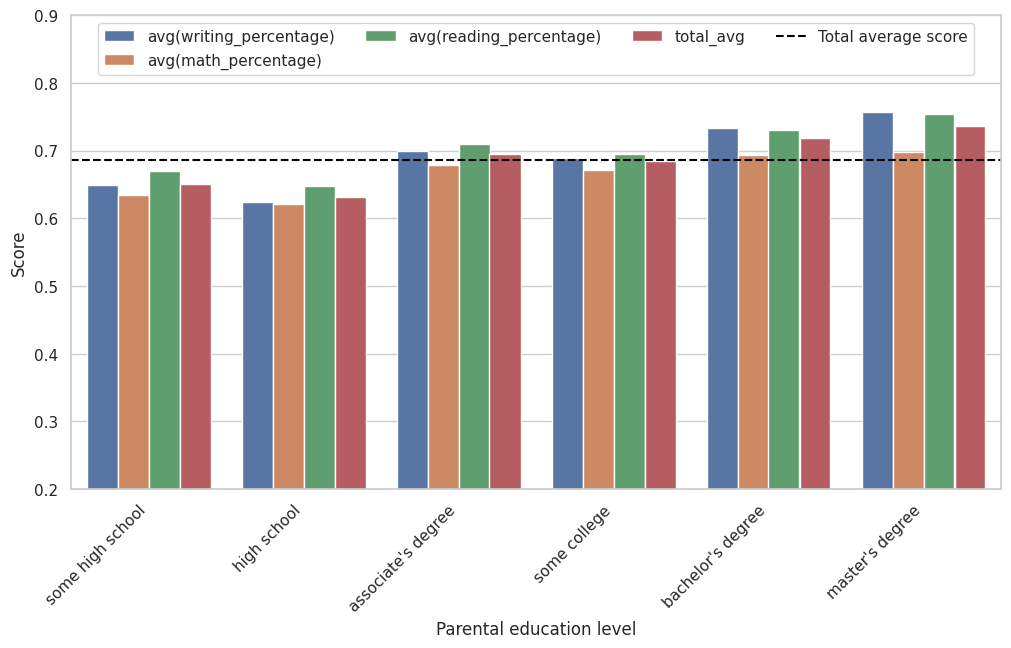

In [54]:
df_edpanda = df_education.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.subplots_adjust(top=0.9)

ax = sns.barplot(x='parental_education', y='value', hue='variable', data=pd.melt(df_edpanda, id_vars='parental_education'))

mean_line = df_edpanda['total_avg'].mean()
plt.axhline(y=mean_line, color='black', linestyle='--', label='Total average score')

plt.legend(loc='upper center', ncol=4)
plt.xlabel('Parental education level')
plt.ylabel('Score')


plt.ylim(0.2, 0.9)
plt.title('')

plt.xticks(rotation=45, ha='right')

plt.show()



## "How does the lunch type affect the educational level of their children?"

In [56]:
from pyspark.sql.functions import col

marksColumns = [col('writing_percentage'), col('math_percentage'), col('reading_percentage')]

averageFunc = sum(x for x in marksColumns)/len(marksColumns)

data = data.withColumn('total_avg', averageFunc)

data.show(3)

+-----+--------------+------------------+--------+-----------------------+---------------+------------------+------------------+---+------------------+
|index|race_ethnicity|parental_education|   lunch|test_preparation_course|math_percentage|reading_percentage|writing_percentage|sex|         total_avg|
+-----+--------------+------------------+--------+-----------------------+---------------+------------------+------------------+---+------------------+
|    0|       group B| bachelor's degree|standard|                   none|           0.72|              0.72|              0.74|  F|0.7266666666666666|
|    1|       group C|      some college|standard|              completed|           0.69|               0.9|              0.88|  F|0.8233333333333333|
|    2|       group B|   master's degree|standard|                   none|            0.9|              0.95|              0.93|  F|0.9266666666666667|
+-----+--------------+------------------+--------+-----------------------+--------------

In [62]:
df_lunchs = data.groupBy('lunch').agg(
    {'writing_percentage':'mean', 'math_percentage':'mean', 'reading_percentage':'mean','total_avg':'mean' }
)

df_lunchs.show()

+------------+-----------------------+------------------+--------------------+-----------------------+
|       lunch|avg(writing_percentage)|    avg(total_avg)|avg(math_percentage)|avg(reading_percentage)|
+------------+-----------------------+------------------+--------------------+-----------------------+
|free/reduced|     0.6302253521126763|0.6219906103286382|  0.5892112676056344|     0.6465352112676062|
|    standard|     0.7082325581395355| 0.708372093023256|   0.700341085271318|     0.7165426356589147|
+------------+-----------------------+------------------+--------------------+-----------------------+



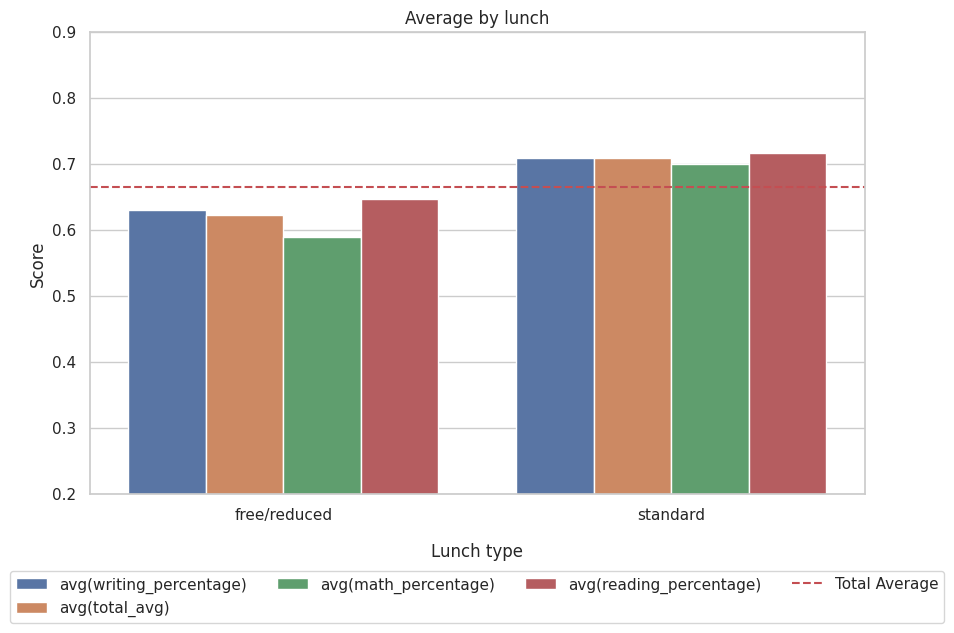

In [68]:
df_lunch = df_lunchs.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='lunch', y='value', hue='variable', data=pd.melt(df_lunch, id_vars='lunch'))

mean_line = df_lunch['avg(total_avg)'].mean()
plt.axhline(y=mean_line, color='r', linestyle='--', label='Total Average')

# Ajustar leyendas y etiquetas
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.xlabel('Lunch type', labelpad=15)
plt.ylabel('Score')
plt.ylim(0.2, 0.9)
plt.title('Average by lunch')

# Mostrar el gráfico
plt.show()

### How many students of each racial group are there?

In [ ]:
count_race = data.groupBy('race_ethnicity').count()
count_race.show()

+--------------+-----+
|race_ethnicity|count|
+--------------+-----+
|       group B|  190|
|       group C|  319|
|       group D|  262|
|       group A|   89|
|       group E|  140|
+--------------+-----+



### What is the pass rate for each subject?

In [70]:
from pyspark.sql.functions import expr

#status column
data = data.withColumn('status', expr('CASE WHEN math_percentage >= 0.5 AND reading_percentage >= 0.5 AND writing_percentage >= 0.5 THEN "Pass" ELSE "Fail" END'))

# Rates
total_students = data.count()
approved_percentage = data.filter(data.status == 'Pass').count() / total_students * 100
failed_percentage = data.filter(data.status == 'Fail').count() / total_students * 100

# Mostrar los resultados
print(f"Pass Rate: {approved_percentage:.2f}%")
print(f"Fail Rate: {failed_percentage:.2f}%")


Pass Rate: 81.20%
Fail Rate: 18.80%


In [76]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField

def get_subject_status(math, reading, writing):
    if math >= 0.5:
        math_status = 'Pass'
    else:
        math_status = 'Fail'

    if reading >= 0.5:
        reading_status = 'Pass'
    else:
        reading_status = 'Fail'

    if writing >= 0.5:
        writing_status = 'Pass'
    else:
        writing_status = 'Fail'

    return math_status, reading_status, writing_status

# UDF
udf_get_subject_status = udf(get_subject_status, StructType([
    StructField("math_status", StringType(), True),
    StructField("reading_status", StringType(), True),
    StructField("writing_status", StringType(), True)
]))

In [77]:
df = data.withColumn('subject_status', udf_get_subject_status('math_percentage', 'reading_percentage', 'writing_percentage'))

df = df.withColumn('math_status', df.subject_status.math_status)
df = df.withColumn('reading_status', df.subject_status.reading_status)
df = df.withColumn('writing_status', df.subject_status.writing_status)

total_students = df.count()
math_pass_percentage = df.filter(df.math_status == 'Pass').count() / total_students * 100
math_fail_percentage = df.filter(df.math_status == 'Fail').count() / total_students * 100

reading_pass_percentage = df.filter(df.reading_status == 'Pass').count() / total_students * 100
reading_fail_percentage = df.filter(df.reading_status == 'Fail').count() / total_students * 100

writing_pass_percentage = df.filter(df.writing_status == 'Pass').count() / total_students * 100
writing_fail_percentage = df.filter(df.writing_status == 'Fail').count() / total_students * 100


print(f"Percentage of students passing in Math: {math_pass_percentage:.2f}%")
print(f"Percentage of students failing in Math: {math_fail_percentage:.2f}%")
print()
print(f"Percentage of students passing in Reading: {reading_pass_percentage:.2f}%")
print(f"Percentage of students failing in Reading: {reading_fail_percentage:.2f}%")
print()
print(f"Percentage of students passing in Writing: {writing_pass_percentage:.2f}%")
print(f"Percentage of students failing in Writing: {writing_fail_percentage:.2f}%")



Percentage of students passing in Math: 86.50%
Percentage of students failing in Math: 13.50%

Percentage of students passing in Reading: 91.00%
Percentage of students failing in Reading: 9.00%

Percentage of students passing in Writing: 88.60%
Percentage of students failing in Writing: 11.40%


 ## Correlation

In [79]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F

In [82]:
indexer_race = StringIndexer(inputCol='race_ethnicity', outputCol='race_numeric')
indexer_education = StringIndexer(inputCol='parental_education', outputCol='education_numeric')
indexer_lunch = StringIndexer(inputCol='lunch', outputCol='lunch_numeric')

data = indexer_race.fit(data).transform(data)
data = indexer_education.fit(data).transform(data)
data = indexer_lunch.fit(data).transform(data)

numeric_columns = ['math_percentage', 'reading_percentage', 'writing_percentage', 'race_numeric', 'education_numeric', 'lunch_numeric']

assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
df_assembled = assembler.transform(data)

correlation_matrix = Correlation.corr(df_assembled, 'features').head()

corr_matrix = correlation_matrix[0].toArray()

print("Correlation Matrix:")
for i in range(len(numeric_columns)):
    for j in range(len(numeric_columns)):
        print(f"{corr_matrix[i, j]:.2f}", end="\t")
    print()


Correlation Matrix:
1.00	0.82	0.80	0.05	0.00	-0.35	
0.82	1.00	0.95	-0.02	0.05	-0.23	
0.80	0.95	1.00	-0.05	0.06	-0.25	
0.05	-0.02	-0.05	1.00	0.00	-0.01	
0.00	0.05	0.06	0.00	1.00	0.02	
-0.35	-0.23	-0.25	-0.01	0.02	1.00	


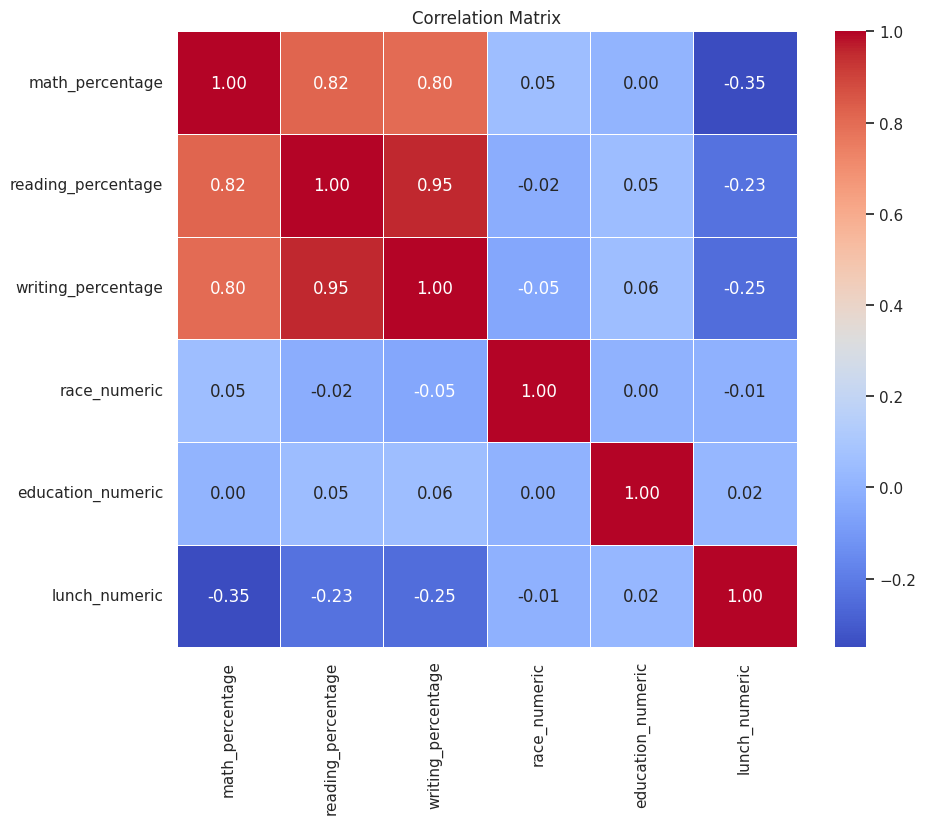

In [83]:
corr_matrix = correlation_matrix[0].toArray()

column_names = numeric_columns
corr_df = pd.DataFrame(corr_matrix, columns=column_names, index=column_names)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()